# Non-adaptive Scalar [Quantization](https://en.wikipedia.org/wiki/Quantization_(signal_processing)) of Digital Signals

In [1]:
!pip install Pygments
%matplotlib inline

import math
import numpy as np

import common
#!ln -sf ~/repos/image_IO/logging_config.py .

## A.  Uniform Quantization

### A.a. [Mid-tread ("round") Quantization](https://en.wikipedia.org/wiki/Quantization_(signal_processing)#Example)

Mid-tread quantizers are uniform quantizers (the decision levels are spaced evenly) and has zero as one of its output (dequantized) levels.

Quantization index:
\begin{equation}
k = \left\lfloor \frac{\left| x \right|}{\Delta} + \frac{1}{2}\right\rfloor.
\end{equation}

Reconstructed value:
\begin{equation}
  y = \Delta k.
\end{equation}

The $k$ index can be also computed using the [round half toward zero](https://en.wikipedia.org/wiki/Rounding#Round_half_towards_zero) (or round to the nearest integer), for which NumPy provides the method [rint()](https://numpy.org/doc/stable/reference/generated/numpy.rint.html).

In [2]:
!pip uninstall -v -y "scalar_quantization @ git+https://github.com/vicente-gonzalez-ruiz/scalar_quantization"

Found existing installation: scalar_quantization 0.0.1
Uninstalling scalar_quantization-0.0.1:
  Removing file or directory /home/vruiz/enviroments/SM/lib/python3.10/site-packages/scalar_quantization-0.0.1.dist-info/
  Removing file or directory /home/vruiz/enviroments/SM/lib/python3.10/site-packages/scalar_quantization/
  Successfully uninstalled scalar_quantization-0.0.1


In [ ]:
!pip --no-cache-dir install "scalar_quantization @ git+https://github.com/vicente-gonzalez-ruiz/scalar_quantization"

  Cloning https://github.com/vicente-gonzalez-ruiz/scalar_quantization to /tmp/pip-install-c1t6tnae/scalar-quantization_0d62c9a871f3438792c4910fd69c2b85
  Running command git clone --filter=blob:none --quiet https://github.com/vicente-gonzalez-ruiz/scalar_quantization /tmp/pip-install-c1t6tnae/scalar-quantization_0d62c9a871f3438792c4910fd69c2b85
  Resolved https://github.com/vicente-gonzalez-ruiz/scalar_quantization to commit f943363a77145e9b902d0897c12def87aa76beeb
  Running command git submodule update --init --recursive -q
  Installing build dependencies ... /

In [4]:
!pygmentize ../../src/scalar_quantization/midtread_quantization.py

'''Mid-read (round) scalar quantization.'''

import numpy as np
from .quantization import Quantizer

name = "mid-tread"

class Midtread_Quantizer(Quantizer):

    def encode(self, x):
        k = np.rint(x / self.Q_step).astype(np.int)
        return k

    def decode(self, k):
        y = self.Q_step * k
        return y


In [7]:
from scalar_quantization.midtread_quantization import Midtread_Quantizer as Quantizer

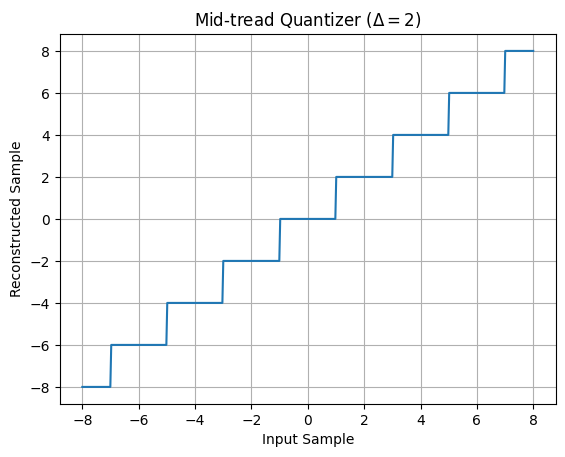

In [8]:
Q_step = 2
Q = Quantizer(Q_step=Q_step, min_val=-128, max_val=127)
x = np.linspace(-8, 8, 500) # Input samples
y, k = Q.encode_and_decode(x)
common.plot(x, y, "Input Sample", "Reconstructed Sample", "Mid-tread Quantizer ($\Delta={}$)".format(Q_step))

The reconstruction levels are in the middle of each bin (this is true for all the non-adaptive quantizers). For example, the values between -1 and 1 ($\Delta=2$) are reconstructed as 0. The values between 1 and 3, are reconstructed by 2.

Depending on the resolution of the input (digital) signal $x$ and quantization step size $\Delta$, the bins can have different size:

In [9]:
x = np.arange(15)-7
y, k = Q.encode_and_decode(x)
print(x)
print(k)
print(y)

[-7 -6 -5 -4 -3 -2 -1  0  1  2  3  4  5  6  7]
[-4 -3 -2 -2 -2 -1  0  0  0  1  2  2  2  3  4]
[-8 -6 -4 -4 -4 -2  0  0  0  2  4  4  4  6  8]


... but this effect is only noticeable if the resolution of $x$ and the size of $\Delta$ are comparable.

### A.b. [Mid-tread Quantization with Deadzone](https://en.wikipedia.org/wiki/Quantization_(signal_processing)#Dead-zone_quantizers)

Deadzone quantizers are characterized by using a bin of size $2\Delta$ centered at the 0 input. See *JPEG2000 Image Compression Fundamentals, Standards and Practice*.

Quantization index
\begin{equation}
k = \left\{ 
  \begin{array}{cl}
    \text{sign}(x) \left\lfloor \frac{\left| x \right|}{\Delta}\right\rfloor & \quad \text{if } \frac{\left| x \right|}{\Delta} >0 \\
    0                 & \quad \textrm{otherwise},
  \end{array}
\right.
\end{equation}
which can be computed efficiently in NumPy by simply converting the floating point representation of $x/\Delta$ to an integer using the [astype()](https://numpy.org/doc/stable/reference/generated/numpy.ndarray.astype.html) method.
Reconstructed value

\begin{equation}
y = \left\{ 
  \begin{array}{cl}
    0                                          & \quad \text{if } k=0 \\
    \text{sign}(k) (\left| k \right|-0.5)\Delta & \quad \text{if } k\ne 0 
  \end{array}
\right.
\end{equation}

Using the same simplification, the second equation boils down to
\begin{equation}
  y = \Delta k.
\end{equation}


In [11]:
!pygmentize ../../src/scalar_quantization/deadzone_quantization.py
from scalar_quantization.deadzone_quantization import Deadzone_Quantizer as Quantizer

'''Uniform Scalar Deadzone Quantization.'''

import numpy as np
from .quantization import Quantizer

name = "dead-zone"

class Deadzone_Quantizer(Quantizer):
    
    def encode(self, x):
        k = (x / self.Q_step).astype(np.int)
        return k

    def decode(self, k):
        y = np.where(k < 0, self.Q_step * (k - 0.5), k)
        y = np.where(k > 0, self.Q_step * (k + 0.5), y)
        #y = self.Q_step * k
        return y


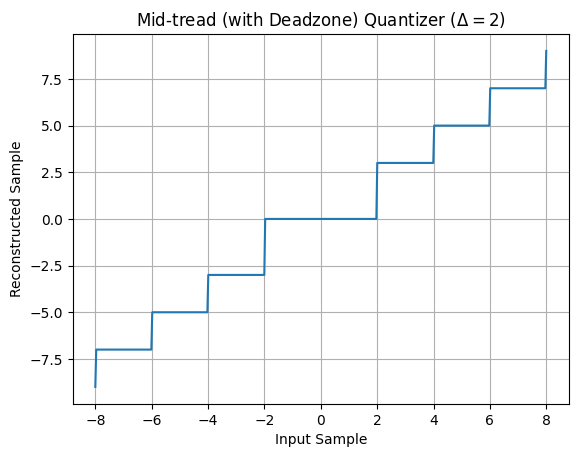

In [12]:
Q_step = 2
Q = Quantizer(Q_step=Q_step, min_val=-128, max_val=127)
x = np.linspace(-8, 8, 500) # Input samples
y, k = Q.encode_and_decode(x)
common.plot(x, y, "Input Sample", "Reconstructed Sample", "Mid-tread (with Deadzone) Quantizer ($\Delta={}$)".format(Q_step))

In [13]:
x = np.arange(15)-7
y, k = Q.encode_and_decode(x)
print(x)
print(k)
print(y)

[-7 -6 -5 -4 -3 -2 -1  0  1  2  3  4  5  6  7]
[-3 -3 -2 -2 -1 -1  0  0  0  1  1  2  2  3  3]
[-7. -7. -5. -5. -3. -3.  0.  0.  0.  3.  3.  5.  5.  7.  7.]


### A.c. [Mid-rise ("truncation") Quantization](https://en.wikipedia.org/wiki/Quantization_(signal_processing)#Mid-riser_and_mid-tread_uniform_quantizers)

Mid-rise quantizers do not have zero as one of its representation levels (in fact, at 0, the output is $\Delta/2$).

Quantization index
\begin{equation}
  k=\Big\lfloor \frac{x}{\Delta}\Big\rfloor.
\end{equation}

Reconstructed value
\begin{equation}
  y = \Delta \Big(k + \frac{1}{2}\Big).
\end{equation}

In [14]:
!pygmentize ../../src/scalar_quantization/midrise_quantization.py
from scalar_quantization.midrise_quantization import Midrise_Quantizer as Quantizer

'''Mid-rise scalar quantization.'''

import numpy as np
from .quantization import Quantizer

name = "mid-rise"

class Midrise_Quantizer(Quantizer):
        
    def encode(self, x):
        k = np.floor(x / self.Q_step).astype(np.int)
        return k

    def decode(self, k):
        y = self.Q_step * (k + 0.5)
        return y

class Midrise_Quantizer2(Quantizer):
    def __init__(self, Q_step, min_val=0, max_val=255):
        super().__init__(Q_step, min_val, max_val)
        N_clusters = (self.max_val + 1 - self.min_val) // Q_step
        #self.decision_levels = np.linspace(min_val, max_val + 1, N_clusters + 1)
        self.centroids = 0.5 * (self.decision_levels[1:] + self.decision_levels[:-1])  # mean

    def quantize(self, x):
        k = np.searchsorted(self.decision_levels, x) - 1
        return k

    def dequantize(self, k):
        y = self.centroids[k]
        return y


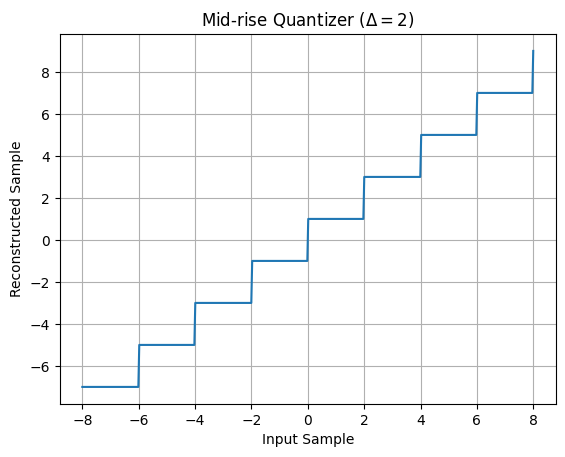

In [15]:
Q_step = 2
Q = Quantizer(Q_step=Q_step, min_val=-128, max_val=127)
x = np.linspace(-8, 8, 500) # Input samples
y, k = Q.encode_and_decode(x)
common.plot(x, y, "Input Sample", "Reconstructed Sample", "Mid-rise Quantizer ($\Delta={}$)".format(Q_step))

In [16]:
x = np.arange(15)-7
y, k = Q.encode_and_decode(x)
print(x)
print(k)
print(y)

[-7 -6 -5 -4 -3 -2 -1  0  1  2  3  4  5  6  7]
[-4 -3 -3 -2 -2 -1 -1  0  0  1  1  2  2  3  3]
[-7. -5. -5. -3. -3. -1. -1.  1.  1.  3.  3.  5.  5.  7.  7.]


## B. [Non Uniform Quantization](https://nptel.ac.in/content/storage2/courses/117104069/chapter_5/5_5.html)

### B.a. [Companded (COMpressed + exPANDED)](https://en.wikipedia.org/wiki/Companding) Quantization

The bins are smaller at the input 0 and viceversa. This can be interesing if most of the samples are small (in absolute value), because we will minimize the quantization error.

#### B.a.1. [$\mu$-Law](https://en.wikipedia.org/wiki/%CE%9C-law_algorithm) Companded  Quantization

Compressor
\begin{equation}
C(x) = \text{sgn}(x) \frac{\ln(1+ \mu |x|)}{\ln(1+\mu)}, ~~~~-1 \leq x \leq 1,
\end{equation}
shere $\mu=255$ in most implementations.

Expander:
\begin{equation}
C^{-1}(y) = \text{sgn}(y) (1 / \mu ) ((1 + \mu)^{|y|}- 1),~~~~-1 \leq y \leq 1.
\end{equation}

In [17]:
!pygmentize ../../src/scalar_quantization/companded_quantization.py
from scalar_quantization.companded_quantization import Companded_Quantizer as Quantizer

'''Companded (using mu-law) scalar quantization.'''

import numpy as np
from .quantization import Quantizer
import deadzone_quantization as deadzone

name = "companded"

class Companded_Quantizer(deadzone.Deadzone_Quantizer):

    def muLaw_compress(self, x, mu):
        return np.log(1+mu*np.abs(x))/np.log(1+mu)*np.sign(x)

    def muLaw_expand(self, y, mu):
        return (1/mu)*(((1+mu)**np.abs(y))-1)*np.sign(y)

    def encode(self, x):
        '''Companded mu-law deadzone quantizer'''
        mu = 255
        x_compressed = (32768*(self.muLaw_compress(x/32768, mu)))
        k = super().encode(x_compressed).astype(np.int16) # Ojo, sobra astype
        return k

    def decode(self, k):
        '''Companded mu-law deadzone dequantizer'''
        mu = 255
        z_compressed = super().decode(k)
        y = np.round(32768*self.muLaw_expand(z_compressed/32768, mu)).astype(np.int16) # Ojo, lo mismo sobra el astype
        return y


ModuleNotFoundError: No module named 'deadzone_quantization'

In [ ]:
x = np.linspace(-1, 1, 500)
Q = companded.Companded_Quantizer(Q_step=Q_step, min_val=-128, max_val=127)

mu = 255
y = Q.muLaw_compress(x, mu)
common.plot(x, y, "Input", "Output", "$\mu$-law Compressor ($\mu={}$)".format(mu))

In [ ]:
x = np.linspace(-1, 1, 500)

mu = 255
y = Q.muLaw_expand(x, mu)
common.plot(x, y, "Input", "Output", "$\mu$-law Expander ($\mu={}$)".format(mu))

In [ ]:
mu = 255
x = np.linspace(-1, 1, 500)
y = Q.muLaw_compress(x, mu)
x_recons = Q.muLaw_expand(y, mu)
common.plot(x, x_recons, "Input", "Output", "Expansion(Compression(Input))".format(mu))

After these definitions, we define the quantization index
\begin{equation}
  k = Q\big(C(x)\big),
\end{equation}
where $C$ is the compression function and $Q$ is a dead-zone quantizer. 

Reconstruction value
\begin{equation}
  y = C^{-1}\big(Q^{-1}(k)\big),
\end{equation}
where $Q^{-1}$ stands for the dead-zone dequantizer and $C^{-1}$ for the expander function.

In [ ]:
Q_step = 1024
min_val = -32767
max_val = 32767
x = np.linspace(min_val, max_val, 500)
Q = companded.Companded_Quantizer(Q_step=Q_step, min_val=min_val, max_val=max_val)
y, k = Q.encode_and_decode(x)
common.plot(x, y, "Input Sample", "Reconstructed Sample", "Companded Dead-zone $\mu$-Law Quantizer ($\mu={}, \Delta={}$)".format(mu, Q_step))

### A.c. [Dead-zone Quantization](https://en.wikipedia.org/wiki/Quantization_(signal_processing)#Dead-zone_quantizers)

See *JPEG2000 Image Compression Fundamentals, Standards and Practice*.

Quantization index
\begin{equation}
k = \left\{ 
  \begin{array}{cl}
    \text{sign}(x) \left\lfloor \frac{\left| x \right|}{\Delta}\right\rfloor & \quad \text{if } \frac{\left| x \right|}{\Delta} >0 \\
    0                 & \quad \textrm{otherwise},
  \end{array}
\right.
\end{equation}
which can be computed efficiently in NumPy by simply converting the floating point representation of $x/\Delta$ to an integer using the [astype()](https://numpy.org/doc/stable/reference/generated/numpy.ndarray.astype.html) method.
Reconstructed value

\begin{equation}
y = \left\{ 
  \begin{array}{cl}
    0                                          & \quad \text{if } k=0 \\
    \text{sign}(k) (\left| k \right|-0.5)\Delta & \quad \text{if } k\ne 0 
  \end{array}
\right.
\end{equation}

Using the same simplification, the second equation boils down to
\begin{equation}
  y = \Delta k.
\end{equation}


In [ ]:
!!pygmentize deadzone_quantization.py
import deadzone_quantization as deadzone

In [ ]:
x = np.arange(11)-5

In [ ]:
print("x =", x)
print("k =", np.rint(x/Q_step).astype(np.int16))

In [ ]:
Q.quantize(x)

In [ ]:
x = np.array([65])
Q_step = 128
Q = midtread.Midtread_Quantizer(Q_step=Q_step, min_val=-128, max_val=127)
k = Q.encode(x)
y = Q.decode(k)
print("k =", k)
print("y =", y)

In [ ]:
print("x =", x)
print("k =", np.floor(x/Q_step).astype(np.int16))

In [ ]:
x = np.array([65])
Q_step = 128
Q = midrise.Midrise_Quantizer(Q_step=Q_step, min_val=-128, max_val=127)
k = Q.encode(x)
y = Q.decode(k)
print("k =", k)
print("y =", y)

### A.c. [Dead-zone Quantization](https://en.wikipedia.org/wiki/Quantization_(signal_processing)#Dead-zone_quantizers)

See *JPEG2000 Image Compression Fundamentals, Standards and Practice*.

Quantization index
\begin{equation}
k = \left\{ 
  \begin{array}{cl}
    \text{sign}(x) \left\lfloor \frac{\left| x \right|}{\Delta}\right\rfloor & \quad \text{if } \frac{\left| x \right|}{\Delta} >0 \\
    0                 & \quad \textrm{otherwise},
  \end{array}
\right.
\end{equation}
which can be computed efficiently in NumPy by simply converting the floating point representation of $x/\Delta$ to an integer using the [astype()](https://numpy.org/doc/stable/reference/generated/numpy.ndarray.astype.html) method.
Reconstructed value

\begin{equation}
y = \left\{ 
  \begin{array}{cl}
    0                                          & \quad \text{if } k=0 \\
    \text{sign}(k) (\left| k \right|-0.5)\Delta & \quad \text{if } k\ne 0 
  \end{array}
\right.
\end{equation}

Using the same simplification, the second equation boils down to
\begin{equation}
  y = \Delta k.
\end{equation}


In [ ]:
print("x =", x)
print("k =", np.sign(x)*np.floor(np.abs(x)/Q_step).astype(np.int16))
print("k =", (x/Q_step).astype(np.int16))

In [ ]:
x = np.array([127])
Q_step = 128
Q = deadzone.Deadzone_Quantizer(Q_step=Q_step, min_val=-128, max_val=127)
k = Q.encode(x)
y = Q.decode(k)
print("k =", k)
print("y =", y)

In [ ]:
!pygmentize deadzone_quantization.py
import deadzone_quantization as deadzone

## Comparing Quantizers I/O

In [ ]:
Q_step = 1 # Delta
x = np.linspace(-8, 8, 500) # Input samples
Q = midtread.Midtread_Quantizer(Q_step=Q_step, min_val=0, max_val=255)
y_T, k_T = Q.encode_and_decode(x)
Q = midrise.Midrise_Quantizer(Q_step=Q_step, min_val=0, max_val=255)
y_R, k_R = Q.encode_and_decode(x)
Q = deadzone.Deadzone_Quantizer(Q_step=Q_step, min_val=0, max_val=255)
y_D, k_D = Q.encode_and_decode(x)
Q = companded.Companded_Quantizer(Q_step=Q_step, min_val=0, max_val=255)
y_C, k_C = Q.encode_and_decode(x)
common.plot(x, y_T, "Input Sample", "Reconstructed Sample", "Mid-tread Quantizer ($\Delta={}$)".format(Q_step))
common.plot(x, y_R, "Input Sample", "Reconstructed Sample", "Mid-rise Quantizer ($\Delta={}$)".format(Q_step))
common.plot(x, y_D, "Input Sample", "Reconstructed Sample", "Dead-zone Quantizer ($\Delta={}$)".format(Q_step))
common.plot(x, y_C, "Input Sample", "Reconstructed Sample", "Companded Dead-zone $\mu$-Law Quantizer ($\mu={}, \Delta={}$)".format(mu, Q_step))

In [ ]:
error_T = x - y_T
error_R = x - y_R
error_D = x - y_D
error_C = x - y_C
common.plot(x, error_T, "Input Sample", "Quantization Error", "Mid-tread Quantizer ($\Delta={}$)".format(Q_step))
common.plot(x, error_R, "Input Sample", "Quantization Error", "Mid-rise Quantizer ($\Delta={}$)".format(Q_step))
common.plot(x, error_D, "Input Sample", "Quantization Error", "Dead-zone Quantizer ($\Delta={}$)".format(Q_step))
common.plot(x, error_C, "Input Sample", "Quantization Error", "Companded Dead-zone $\mu$-Law Quantizer ($\mu={}, \Delta={}$)".format(mu, Q_step))

In [ ]:
Q_step = 2
x = np.linspace(-8, 8, 500)
Q = midtread.Midtread_Quantizer(Q_step=Q_step, min_val=0, max_val=255)
y_T, k_T = Q.encode_and_decode(x)
Q = midrise.Midrise_Quantizer(Q_step=Q_step, min_val=0, max_val=255)
y_R, k_R = Q.encode_and_decode(x)
Q = deadzone.Deadzone_Quantizer(Q_step=Q_step, min_val=0, max_val=255)
y_D, k_D = Q.encode_and_decode(x)
Q = companded.Companded_Quantizer(Q_step=Q_step, min_val=0, max_val=255)
y_C, k_C = Q.encode_and_decode(x)
common.plot(x, y_T, "Input Sample", "Reconstructed Sample", "Mid-tread Quantizer ($\Delta={}$)".format(Q_step))
common.plot(x, y_R, "Input Sample", "Reconstructed Sample", "Mid-rise Quantizer ($\Delta={}$)".format(Q_step))
common.plot(x, y_D, "Input Sample", "Reconstructed Sample", "Dead-zone Quantizer ($\Delta={}$)".format(Q_step))
common.plot(x, y_C, "Input Sample", "Reconstructed Sample", "Companded Dead-zone $\mu$-Law Quantizer ($\mu={}, \Delta={}$)".format(mu, Q_step))

In [ ]:
error_T = x - y_T
error_R = x - y_R
error_D = x - y_D
error_C = x - y_C
common.plot(x, error_T, "Input Sample", "Quantization Error", "Mid-tread Quantizer ($\Delta={}$)".format(Q_step))
common.plot(x, error_R, "Input Sample", "Quantization Error", "Mid-rise Quantizer ($\Delta={}$)".format(Q_step))
common.plot(x, error_D, "Input Sample", "Quantization Error", "Dead-zone Quantizer ($\Delta={}$)".format(Q_step))
common.plot(x, error_C, "Input Sample", "Quantization Error", "Companded Dead-zone $\mu$-Law Quantizer ($\mu={}, \Delta={}$)".format(mu, Q_step))

In [ ]:
Q_step = 3
x = np.linspace(-8, 8, 500)
Q = midtread.Midtread_Quantizer(Q_step=Q_step, min_val=0, max_val=255)
y_T, k_T = Q.encode_and_decode(x)
Q = midrise.Midrise_Quantizer(Q_step=Q_step, min_val=0, max_val=255)
y_R, k_R = Q.encode_and_decode(x)
Q = deadzone.Deadzone_Quantizer(Q_step=Q_step, min_val=0, max_val=255)
y_D, k_D = Q.encode_and_decode(x)
Q = companded.Companded_Quantizer(Q_step=Q_step, min_val=0, max_val=255)
y_C, k_C = Q.encode_and_decode(x)
common.plot(x, y_T, "Input Sample", "Reconstructed Sample", "Mid-tread Quantizer ($\Delta={}$)".format(Q_step))
common.plot(x, y_R, "Input Sample", "Reconstructed Sample", "Mid-rise Quantizer ($\Delta={}$)".format(Q_step))
common.plot(x, y_D, "Input Sample", "Reconstructed Sample", "Dead-zone Quantizer ($\Delta={}$)".format(Q_step))
common.plot(x, y_C, "Input Sample", "Reconstructed Sample", "Companded Dead-zone $\mu$-Law Quantizer ($\mu={}, \Delta={}$)".format(mu, Q_step))

In [ ]:
error_T = x - y_T
error_R = x - y_R
error_D = x - y_D
error_C = x - y_C
common.plot(x, error_T, "Input Sample", "Quantization Error", "Mid-tread Quantizer ($\Delta={}$)".format(Q_step))
common.plot(x, error_R, "Input Sample", "Quantization Error", "Mid-rise Quantizer ($\Delta={}$)".format(Q_step))
common.plot(x, error_D, "Input Sample", "Quantization Error", "Dead-zone Quantizer ($\Delta={}$)".format(Q_step))
common.plot(x, error_C, "Input Sample", "Quantization Error", "Companded Dead-zone $\mu$-Law Quantizer ($\mu={}, \Delta={}$)".format(mu, Q_step))

In [ ]:
Q_step = 4
x = np.linspace(-8, 8, 500)
Q = midtread.Midtread_Quantizer(Q_step=Q_step, min_val=0, max_val=255)
y_T, k_T = Q.encode_and_decode(x)
Q = midrise.Midrise_Quantizer(Q_step=Q_step, min_val=0, max_val=255)
y_R, k_R = Q.encode_and_decode(x)
Q = deadzone.Deadzone_Quantizer(Q_step=Q_step, min_val=0, max_val=255)
y_D, k_D = Q.encode_and_decode(x)
Q = companded.Companded_Quantizer(Q_step=Q_step, min_val=0, max_val=255)
y_C, k_C = Q.encode_and_decode(x)
common.plot(x, y_T, "Input Sample", "Reconstructed Sample", "Mid-tread Quantizer ($\Delta={}$)".format(Q_step))
common.plot(x, y_R, "Input Sample", "Reconstructed Sample", "Mid-rise Quantizer ($\Delta={}$)".format(Q_step))
common.plot(x, y_D, "Input Sample", "Reconstructed Sample", "Dead-zone Quantizer ($\Delta={}$)".format(Q_step))
common.plot(x, y_C, "Input Sample", "Reconstructed Sample", "Companded Dead-zone $\mu$-Law Quantizer ($\mu={}, \Delta={}$)".format(mu, Q_step))

In [ ]:
error_T = x - y_T
error_R = x - y_R
error_D = x - y_D
error_C = x - y_C
common.plot(x, error_T, "Input Sample", "Quantization Error", "Mid-tread Quantizer ($\Delta={}$)".format(Q_step))
common.plot(x, error_R, "Input Sample", "Quantization Error", "Mid-rise Quantizer ($\Delta={}$)".format(Q_step))
common.plot(x, error_D, "Input Sample", "Quantization Error", "Dead-zone Quantizer ($\Delta={}$)".format(Q_step))
common.plot(x, error_C, "Input Sample", "Quantization Error", "Companded Dead-zone $\mu$-Law Quantizer ($\mu={}, \Delta={}$)".format(mu, Q_step))

In [ ]:
Q_step = 1024
min_val = -32768
max_val = 32767
x = np.linspace(min_val, max_val, 500)
Q = midtread.Midtread_Quantizer(Q_step=Q_step, min_val=min_val, max_val=max_val)
y_T, k_T = Q.encode_and_decode(x)
Q = midrise.Midrise_Quantizer(Q_step=Q_step, min_val=min_val, max_val=max_val)
y_R, k_R = Q.encode_and_decode(x)
Q = deadzone.Deadzone_Quantizer(Q_step=Q_step, min_val=min_val, max_val=max_val)
y_D, k_D = Q.encode_and_decode(x)
Q = companded.Companded_Quantizer(Q_step=Q_step, min_val=min_val, max_val=max_val)
y_C, k_C = Q.encode_and_decode(x)
common.plot(x, y_T, "Input Sample", "Reconstructed Sample", "Mid-tread Quantizer ($\Delta={}$)".format(Q_step))
common.plot(x, y_R, "Input Sample", "Reconstructed Sample", "Mid-rise Quantizer ($\Delta={}$)".format(Q_step))
common.plot(x, y_D, "Input Sample", "Reconstructed Sample", "Dead-zone Quantizer ($\Delta={}$)".format(Q_step))
common.plot(x, y_C, "Input Sample", "Reconstructed Sample", "Companded Dead-zone $\mu$-Law Quantizer ($\mu={}, \Delta={}$)".format(mu, Q_step))

In [ ]:
error_T = x - y_T
error_R = x - y_R
error_D = x - y_D
error_C = x - y_C
common.plot(x, error_T, "Input Sample", "Quantization Error", "Mid-tread Quantizer ($\Delta={}$)".format(Q_step))
common.plot(x, error_R, "Input Sample", "Quantization Error", "Mid-rise Quantizer ($\Delta={}$)".format(Q_step))
common.plot(x, error_D, "Input Sample", "Quantization Error", "Dead-zone Quantizer ($\Delta={}$)".format(Q_step))
common.plot(x, error_C, "Input Sample", "Quantization Error", "Companded Dead-zone $\mu$-Law Quantizer ($\mu={}, \Delta={}$)".format(mu, Q_step))

## Working with signed integers of 16 bits

In [ ]:
Q_step = 1
x = np.linspace(-32768, 32767, 65536).astype(np.int16)
Q = midtread.Midtread_Quantizer(Q_step=Q_step, min_val=0, max_val=255)
y_T, k_T = Q.encode_and_decode(x)
Q = midrise.Midrise_Quantizer(Q_step=Q_step, min_val=0, max_val=255)
y_R, k_R = Q.encode_and_decode(x)
Q = deadzone.Deadzone_Quantizer(Q_step=Q_step, min_val=0, max_val=255)
y_D, k_D = Q.encode_and_decode(x)
Q = companded.Companded_Quantizer(Q_step=Q_step, min_val=0, max_val=255)
y_C, k_C = Q.encode_and_decode(x)

n = 16
print(f"{'Mid-tread':>20s} {'Mid-rise':>20s} {'Dead-zone':>20s} {'Companded Dead-zone':>20s}")
print(f"{'Input':>6s} {'Output':>6s} {'Recons':>6s} {'Input':>6s} {'Output':>6s} {'Recons':>6s} {'Input':>6s} {'Output':>6s} {'Recons':>6s} {'Input':>6s} {'Output':>6s} {'Recons':>6s}")
offset = (len(x)-n)//2
for i in range(n):
    input = int(x[i+offset])
    output_T = int(k_T[i+offset])
    recons_T = int(y_T[i+offset])
    print(f"{input:>6d} {output_T:>6d} {recons_T:>6d}", end='')
    output_R = int(k_R[i+offset])
    recons_R = int(y_R[i+offset])
    print(f" {input:>6d} {output_R:>6d} {recons_R:>6d}", end='')
    output_D = int(k_D[i+offset])
    recons_D = int(y_D[i+offset])
    print(f" {input:>6d} {output_D:>6d} {recons_D:>6d}", end='')
    output_C = int(k_C[i+offset])
    recons_C = int(y_C[i+offset])
    print(f" {input:>6d} {output_C:>6d} {recons_C:>6d}")


In [ ]:
Q_step = 2
x = np.linspace(-32768, 32767, 65536).astype(np.int16)
Q = midtread.Midtread_Quantizer(Q_step=Q_step, min_val=0, max_val=255)
y_T, k_T = Q.encode_and_decode(x)
Q = midrise.Midrise_Quantizer(Q_step=Q_step, min_val=0, max_val=255)
y_R, k_R = Q.encode_and_decode(x)
Q = deadzone.Deadzone_Quantizer(Q_step=Q_step, min_val=0, max_val=255)
y_D, k_D = Q.encode_and_decode(x)
Q = companded.Companded_Quantizer(Q_step=Q_step, min_val=0, max_val=255)
y_C, k_C = Q.encode_and_decode(x)

n = 16
print(f"{'Mid-tread':>20s} {'Mid-rise':>20s} {'Dead-zone':>20s} {'Companded Dead-zone':>20s}")
print(f"{'Input':>6s} {'Output':>6s} {'Recons':>6s} {'Input':>6s} {'Output':>6s} {'Recons':>6s} {'Input':>6s} {'Output':>6s} {'Recons':>6s} {'Input':>6s} {'Output':>6s} {'Recons':>6s}")
offset = (len(x)-n)//2
for i in range(n):
    input = int(x[i+offset])
    output_T = int(k_T[i+offset])
    recons_T = int(y_T[i+offset])
    print(f"{input:>6d} {output_T:>6d} {recons_T:>6d}", end='')
    output_R = int(k_R[i+offset])
    recons_R = int(y_R[i+offset])
    print(f" {input:>6d} {output_R:>6d} {recons_R:>6d}", end='')
    output_D = int(k_D[i+offset])
    recons_D = int(y_D[i+offset])
    print(f" {input:>6d} {output_D:>6d} {recons_D:>6d}", end='')
    output_C = int(k_C[i+offset])
    recons_C = int(y_C[i+offset])
    print(f" {input:>6d} {output_C:>6d} {recons_C:>6d}")


In [ ]:
Q_step = 32
x = np.linspace(-32768, 32767, 65536).astype(np.int16)
Q = midtread.Midtread_Quantizer(Q_step=Q_step, min_val=0, max_val=255)
y_T, k_T = Q.encode_and_decode(x)
Q = midrise.Midrise_Quantizer(Q_step=Q_step, min_val=0, max_val=255)
y_R, k_R = Q.encode_and_decode(x)
Q = deadzone.Deadzone_Quantizer(Q_step=Q_step, min_val=0, max_val=255)
y_D, k_D = Q.encode_and_decode(x)
Q = companded.Companded_Quantizer(Q_step=Q_step, min_val=0, max_val=255)
y_C, k_C = Q.encode_and_decode(x)

n = 16
print(f"{'Mid-tread':>20s} {'Mid-rise':>20s} {'Dead-zone':>20s} {'Companded Dead-zone':>20s}")
print(f"{'Input':>6s} {'Output':>6s} {'Recons':>6s} {'Input':>6s} {'Output':>6s} {'Recons':>6s} {'Input':>6s} {'Output':>6s} {'Recons':>6s} {'Input':>6s} {'Output':>6s} {'Recons':>6s}")
offset = (len(x)-n)//2
for i in range(n):
    input = int(x[i+offset])
    output_T = int(k_T[i+offset])
    recons_T = int(y_T[i+offset])
    print(f"{input:>6d} {output_T:>6d} {recons_T:>6d}", end='')
    output_R = int(k_R[i+offset])
    recons_R = int(y_R[i+offset])
    print(f" {input:>6d} {output_R:>6d} {recons_R:>6d}", end='')
    output_D = int(k_D[i+offset])
    recons_D = int(y_D[i+offset])
    print(f" {input:>6d} {output_D:>6d} {recons_D:>6d}", end='')
    output_C = int(k_C[i+offset])
    recons_C = int(y_C[i+offset])
    print(f" {input:>6d} {output_C:>6d} {recons_C:>6d}")


## Ignore the rest.

In [ ]:
import time
while True:
    time.sleep(1)